# Intro
The uk_macro_q.csv dataset collects some interesting data with regards to how the London House Price Index relates to some interesting macro-economic indicators. The question we try to answer in this notebook is whether it is possible to cluster these data-points into distinct time periods.

Let's first import and clean the data. To make it easy, mortgage rate are inverted (as they are negatively correlated with house prices). We will also standardize the data to prepare it for our clustering algorithm.

In [20]:
import pandas as pd
df = pd.read_csv('datasets/uk_macro_q.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,London HPI,employment rate,100/mortgage rate,Real_FTSE100,Real GDP PC CHG
Date,,,,,
1995-06-30,18.658309,65.333333,12.274212,49.259713,0.862432
1995-09-30,18.737812,64.633333,12.568520,52.090428,1.313869
1995-12-31,18.501414,64.666667,12.515645,53.965645,0.288184
1996-03-31,18.792822,64.966667,15.123763,55.095228,0.841544
1996-06-30,19.206689,65.633333,14.511794,54.855619,0.040708


In [21]:
from sklearn.preprocessing import StandardScaler
import random

random.seed(1)
ss = StandardScaler().fit_transform(df)
ss = pd.DataFrame(ss, index=df.index, columns=df.columns)
ss.describe()

,London HPI,employment rate,100/mortgage rate,Real_FTSE100,Real GDP PC CHG
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,2.153833e-16,4.005685e-15,-1.776357e-16,-4.496403e-16,-9.769963e-17
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-1.508047e+00,-2.035014e+00,-9.993798e-01,-2.105526e+00,-4.282270e+00
25%,-8.315850e-01,-5.556312e-01,-7.326866e-01,-7.342594e-01,-3.647126e-01
50%,-5.360972e-02,-8.942373e-02,-4.673939e-01,4.666830e-03,1.268177e-01
75%,6.182513e-01,3.951383e-01,5.225051e-01,4.880625e-01,5.261461e-01
max,1.688587e+00,2.531617e+00,2.311572e+00,2.449662e+00,1.975478e+00


Now that the data is standardized we can try to cluster it. We will use the KMeans method. To find the ideal number of clusters we will loop from 3 to 12 clusters. We will look at three metrics to judge the results:
- Silhouette score (The closer to 1 the better)
- Calinsky-Harabasz index (The higher the better)
- Davies-Boulding index (The closer to 0 the better)

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics

for n in range(3, 13):
    print('\n', '...n =', n)
    km = KMeans(n_clusters=n)
    km.fit(ss)
    clusters = km.predict(ss)
    ss['Cluster'] = clusters
    
    print('Silhouette: %.3f' % metrics.silhouette_score(ss, clusters, metric='euclidean'))
    print('Calinski-Harabasz: %.3f' % metrics.calinski_harabasz_score(ss, clusters))
    print('Davies-Bouldin: %.3f' % metrics.davies_bouldin_score(ss, clusters))


 ...n = 3
Silhouette: 0.460
Calinski-Harabasz: 80.196
Davies-Bouldin: 0.864

 ...n = 4
Silhouette: 0.417
Calinski-Harabasz: 72.931
Davies-Bouldin: 0.887

 ...n = 5
Silhouette: 0.524
Calinski-Harabasz: 89.294
Davies-Bouldin: 0.669

 ...n = 6
Silhouette: 0.526
Calinski-Harabasz: 89.218
Davies-Bouldin: 0.580

 ...n = 7
Silhouette: 0.510
Calinski-Harabasz: 115.039
Davies-Bouldin: 0.601

 ...n = 8
Silhouette: 0.489
Calinski-Harabasz: 104.072
Davies-Bouldin: 0.688

 ...n = 9
Silhouette: 0.543
Calinski-Harabasz: 157.323
Davies-Bouldin: 0.610

 ...n = 10
Silhouette: 0.575
Calinski-Harabasz: 176.761
Davies-Bouldin: 0.558

 ...n = 11
Silhouette: 0.523
Calinski-Harabasz: 186.349
Davies-Bouldin: 0.617

 ...n = 12
Silhouette: 0.585
Calinski-Harabasz: 199.526
Davies-Bouldin: 0.563


Depending on how much weight we put on which scoring method we can find different optimal values for k. Taking everything into account a k of 7 seems to be a reasonable estimate. Next we will plot these 7 clusters agains the London HPI.

[Work in progress]

-0.478625    30
 3.362482    19
-1.109619    19
 1.013218    18
-2.907739    10
-5.853425     3
-0.045907     1
Name: Score, dtype: int64


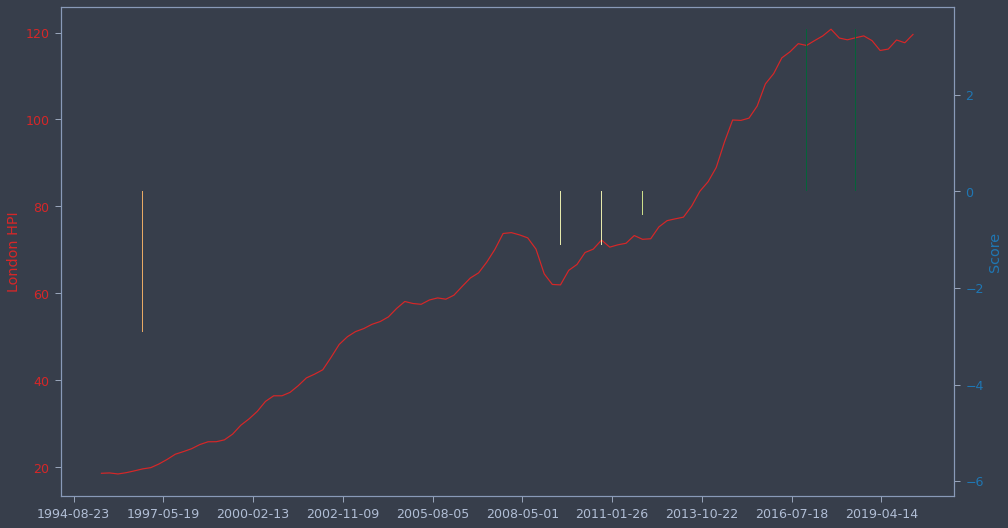

In [31]:
import matplotlib.pyplot as plt
from matplotlib import cm

X = df[[c for c in df.columns if not c in ['London HPI']]]

ss = StandardScaler().fit_transform(X)
ss = pd.DataFrame(ss, index=X.index, columns=X.columns)

km = KMeans(n_clusters=7)
km.fit(ss)
clusters = km.predict(ss)
ss['Cluster'] = clusters

score = ss.groupby('Cluster').mean().sum(axis=1)
ss['Score'] = ss['Cluster'].apply(lambda x: score[x])
ss['London HPI'] = df['London HPI']
print(ss['Score'].value_counts())

fig, ax1 = plt.subplots(figsize=(16,9))

color = 'tab:red'
ax1.set_ylabel('London HPI', color=color)
ax1.plot(ss['London HPI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Score', color=color)
colors = cm.RdYlGn((ss['Score'] - score.min()) / (score.max() - score.min()))
ax2.bar(ss.index, ss['Score'], alpha=0.9, color=colors)
ax2.tick_params(axis='y', labelcolor=color)

ax1.xaxis.set_major_locator(plt.MaxNLocator())
plt.show()

# Exercise 6

In [17]:
import statsmodels.api as sm
import pickle
import copy

random.seed(1)
df = pd.read_csv('ura_data_withproject.csv', index_col=0)
print(df.head(), '\n')
print(df.info(), '\n')

   log_price_psf            Project Name  Area (Sqft)  Type_Condominium  \
0       7.519692     STIRLING RESIDENCES          657                 0   
1       7.290293          WHISTLER GRAND          614                 0   
2       7.670895          MARGARET VILLE          463                 0   
3       7.525101     STIRLING RESIDENCES         1346                 0   
4       7.515889  AVENUE SOUTH RESIDENCE         1109                 0   

   Relative_tenure  SaleType_Resale  SaleType_Sub Sale  Floor_number  \
0         0.914111                0                  0          23.0   
1         0.915692                0                  0          18.0   
2         0.914111                0                  0          38.0   
3         0.914111                0                  0          23.0   
4         0.915692                0                  0           8.0   

   Market Segment_OCR  Market Segment_RCR  ...  Period_2017Q4  Period_2018Q1  \
0                   0               

In [18]:
y = df['log_price_psf']
res = []
per = ['%sQ%s' % (y,q) for y in range(2017,2021) for q in range(1,5)]
per = per[:-3]
print(per)
min_obs = 1000

['2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1']


In [44]:
for start in range(0,len(per)-5+1):
    win = per[start:start+5]
    print('Working on', win[0], 'to', win[-1])
    fil = df['Period_%s' % win[0]] == 1
    for i in [1,2,3,4]:
        fil = fil | (df['Period_%s' % win[i]] ==1)
    fil = copy.deepcopy(df[fil])
    
    # Fit overall model
    print('...fitting overall')
    y = fil['log_price_psf']
    cols = [c for c in df.columns if not c.startswith('Period_') and not c in ['log_price_psf', 'Project Name']]
    X = fil[cols]
    X = sm.add_constant(X)
    
    mod = sm.OLS(y, X)
    res = mod.fit()
    res.save('temp/rolling_%s.pkl' % win[-1])
    
    # Cluster the data
    print('...clustering')
    cols = [c for c in df.columns if not c.startswith('Period_') and not c.startswith('District') and not c.startswith('Type') and not c.startswith('SaleType') and not c.startswith('Market Segment')]
    # cols_std =
    mean = fil.groupby('Project Name')[cols].mean()
    mean.columns = ['%s_mean' % c for c in mean.columns]
    std = fil.groupby('Project Name')[cols].std()
    std.columns = ['%s_std' % c for c in std.columns]
    std.fillna(0, inplace=True)
    clus = pd.concat([mean, std], axis=1)
    
    ss = StandardScaler().fit_transform(clus)
    ss = pd.DataFrame(ss, index=clus.index, columns=clus.columns)
    
    pca = PCA()
    pca.fit_transform(ss)
    red = PCA(n_components=5).fit_transform(ss)
    
    km = KMeans(n_clusters=3)
    km.fit(red)
    lab = km.predict(red)
    ss['Cluster'] = lab
    pickle.dump(ss['Cluster'], open('temp/K3_cluster_%s.pkl' % win[-1], 'wb'))
    fil['Cluster'] = fil['Project Name'].apply(lambda x: ss.loc[x, 'Cluster'])
    
    # Fit one model for each cluster
    clus_gr = fil.groupby('Cluster')
    for c, d in clus_gr:
        c = int(c)
        if len(d) < min_obs:
            print('...skipping cluster', c)
        else:
            print('...fitting cluster', c)
            y = d['log_price_psf']
            cols = [c for c in df.columns if not c.startswith('Period_') and not c in ['log_price_psf', 'Project Name']] + ['Period_%s' % p for p in per[1:5]]
            X = d[cols]
            X = sm.add_constant(X)
            
            mod = sm.OLS(y,X)
            res = mod.fit()
            res.save('temp/rolling_%s_K3_%s.pkl' % (win[-1], c))
print('\nFinished: Models saved in temp folder')

Working on 2017Q1 to 2018Q1
...fitting overall
...clustering
...fitting cluster 0
...skipping cluster 1
...fitting cluster 2
Working on 2017Q2 to 2018Q2
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2017Q3 to 2018Q3
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2017Q4 to 2018Q4
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2018Q1 to 2019Q1
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2018Q2 to 2019Q2
...fitting overall
...clustering
...skipping cluster 0
...fitting cluster 1
...fitting cluster 2
Working on 2018Q3 to 2019Q3
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
Working on 2018Q4 to 2019Q4
...fitting overall
...clustering
...fitting cluster 0
...fitting cluster 1
...skipping cluster 2
